# **A Data-Driven Comparative Analysis of Disability-Adjusted Life Years (DALYs) and Socioeconomic Development Indicators**
## Exploring the Impact of Economic, Educational, and Demographic Factors on Global Health Burden


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical analysis
import scipy.stats as stats
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Warnings (optional)
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


##### **Research Question 1**: Is there a significant correlation between GDP per capita and total DALYs across countries?
##### **Hypothesis** Higher GDP per capita is associated with lower total DALYs.

In [3]:
# Extract GDP per capita data for 2021
worldbank_df = pd.read_csv('dataset/worldbank-datasets-2021.csv')
gdp_per_capita_2021 = worldbank_df[worldbank_df.iloc[:, 0] == "GDP per capita (current US$)"]

# Extract DALYs rate data for 2021
dalys_df = pd.read_csv('dataset/IMHE-GBD-ALL-DALYs-per100k-1990-2021.csv')
dalys_rate_2021 = dalys_df[dalys_df['year'] == 2021]

# Extract population data for 2021
population_df = pd.read_csv('dataset/2021_population.csv')

In [5]:
# Prepare GDP data properly
gdp_df = gdp_per_capita_2021.copy()
# The World Bank data structure: [Indicator, Country, Country Code, Value]
gdp_df.columns = ['indicator', 'country', 'country_code', 'gdp_per_capita']
gdp_df = gdp_df[['country', 'gdp_per_capita']].copy()
gdp_df = gdp_df[gdp_df['gdp_per_capita'].notna()]
# Convert to numeric, replacing '..' with NaN
gdp_df['gdp_per_capita'] = pd.to_numeric(gdp_df['gdp_per_capita'], errors='coerce')
gdp_df = gdp_df.dropna()

# Prepare DALY data
dalys_clean = dalys_rate_2021[['location_name', 'val']].copy()
dalys_clean.columns = ['country', 'dalys_rate']
dalys_clean = dalys_clean[dalys_clean['dalys_rate'].notna()]

# Prepare population data
pop_df = population_df[['country', '2021_last_updated']].copy()
pop_df.columns = ['country', 'population']
pop_df = pop_df[pop_df['population'].notna()]
# Convert population to numeric
pop_df['population'] = pd.to_numeric(pop_df['population'].astype(str).str.replace(',', ''), errors='coerce')
pop_df = pop_df.dropna()

In [6]:
# Check data before merging
print("GDP data shape:", gdp_df.shape)
print("DALY data shape:", dalys_clean.shape)
print("Population data shape:", pop_df.shape)

GDP data shape: (258, 2)
DALY data shape: (204, 2)
Population data shape: (224, 2)


In [7]:
# Merge datasets on country names
df1 = dalys_clean.merge(gdp_df, on='country', how='inner')
df1 = df1.merge(pop_df, on='country', how='inner')
df1.columns = ['countries', 'dalys_rate_2021', 'gdp_per_capita_2021', 'population_2021']

# Display basic info about the dataframe
print(f"DataFrame shape: {df1.shape}")
print(f"Columns: {df1.columns.tolist()}")
print(f"Countries with complete data: {len(df1)}")
if len(df1) > 0:
    df1.head()
else:
    print("No matching countries found. Check country name formats.")

DataFrame shape: (158, 4)
Columns: ['countries', 'dalys_rate_2021', 'gdp_per_capita_2021', 'population_2021']
Countries with complete data: 158


In [8]:
# Merge datasets on country names
df1 = dalys_clean.merge(gdp_df[['country', 'gdp_per_capita']], on='country', how='inner')
df1 = df1.merge(pop_df, on='country', how='inner')

# Rename columns for clarity
df1.columns = ['countries', 'dalys_rate_2021', 'gdp_per_capita_2021', 'population_2021']

# Display basic info about the dataframe
print(f"DataFrame shape: {df1.shape}")
print(f"Columns: {df1.columns.tolist()}")
print(f"Countries with complete data: {len(df1)}")
df1.head()

DataFrame shape: (158, 4)
Columns: ['countries', 'dalys_rate_2021', 'gdp_per_capita_2021', 'population_2021']
Countries with complete data: 158


,countries,dalys_rate_2021,gdp_per_capita_2021,population_2021
0,Afghanistan,54970.40051,356.496214,40374668
1,Albania,34816.53755,6413.282808,2869700
2,Algeria,28024.94386,4160.559267,45061896
3,American Samoa,34224.30229,15236.160490,55100
4,Andorra,27497.83696,42425.699680,77355


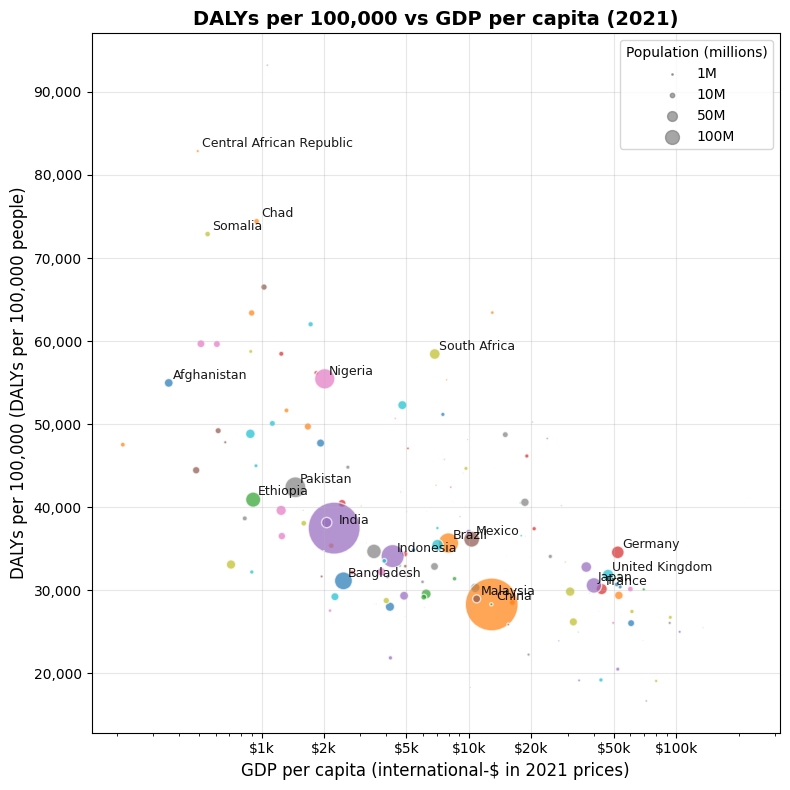


Dataset Statistics:
Number of countries: 158
GDP per capita range: $214 - $223823
DALYs rate range: 16685 - 93225


In [20]:
# Create bubble plot for GDP per capita vs DALYs per 100k using matplotlib
plt.figure(figsize=(8, 8))

# Create the scatter plot with bubble sizes
scatter = plt.scatter(df1['gdp_per_capita_2021'], 
                     df1['dalys_rate_2021'],
                     s=df1['population_2021']/1000000,  # Scale population for bubble size
                     alpha=0.7,
                     c=range(len(df1)),
                     cmap='tab10',
                     edgecolors='white',
                     linewidth=1)

plt.xscale('log')

# Set custom x-axis ticks and labels
x_ticks = [1000, 2000, 5000, 10000, 20000, 50000, 100000]
x_labels = ['$1k', '$2k', '$5k', '$10k', '$20k', '$50k', '$100k']
plt.xticks(x_ticks, x_labels)

# Format y-axis with whole numbers
from matplotlib.ticker import FuncFormatter

def whole_number_formatter(x, pos):
    return f'{x:,.0f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(whole_number_formatter))

# Labels and title
plt.xlabel('GDP per capita (international-$ in 2021 prices)', fontsize=12)
plt.ylabel('DALYs per 100,000 (DALYs per 100,000 people)', fontsize=12)
plt.title('DALYs per 100,000 vs GDP per capita (2021)', fontsize=14, fontweight='bold')

# Add grid
plt.grid(True, alpha=0.3)

# Define major/relevant countries to label
major_countries = ['United States', 'China', 'India', 'Germany', 'Japan', 'United Kingdom', 
                  'France', 'Brazil', 'Russia', 'South Africa', 'Nigeria', 'Ethiopia',
                  'Bangladesh', 'Pakistan', 'Malaysia', 'Indonesia', 'Mexico', 'Turkey', 'Iran',
                  'Afghanistan', 'Central African Republic', 'Chad', 'Somalia']

# Label only major/relevant countries
for i, country in enumerate(df1['countries']):
    if country in major_countries:
        plt.annotate(country, 
                    (df1['gdp_per_capita_2021'].iloc[i], df1['dalys_rate_2021'].iloc[i]),
                    xytext=(3, 3), 
                    textcoords='offset points', 
                    fontsize=9, 
                    alpha=0.9)

# Add legend for bubble sizes
sizes = [1, 10, 50, 100]  # Example population sizes in millions
labels = ['1M', '10M', '50M', '100M']
legend_bubbles = []
for size in sizes:
    legend_bubbles.append(plt.scatter([], [], s=size, alpha=0.7, color='gray'))

plt.legend(legend_bubbles, labels, scatterpoints=1, loc='upper right', 
          title='Population (millions)', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

# Display basic statistics
print(f"\nDataset Statistics:")
print(f"Number of countries: {len(df1)}")
print(f"GDP per capita range: ${df1['gdp_per_capita_2021'].min():.0f} - ${df1['gdp_per_capita_2021'].max():.0f}")
print(f"DALYs rate range: {df1['dalys_rate_2021'].min():.0f} - {df1['dalys_rate_2021'].max():.0f}")

In [21]:
print("=== CORRELATION ANALYSIS: GDP per capita vs DALYs per 100k ===\n")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df1['gdp_per_capita_2021'], df1['dalys_rate_2021'])

# Calculate Pearson correlation for comparison
pearson_corr, pearson_p = pearsonr(df1['gdp_per_capita_2021'], df1['dalys_rate_2021'])

print(f"Spearman Correlation Coefficient: {spearman_corr:.4f}")
print(f"Spearman p-value: {spearman_p:.6f}")
print(f"Statistical significance (α = 0.05): {'Yes' if spearman_p < 0.05 else 'No'}")
print()

print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Pearson p-value: {pearson_p:.6f}")
print(f"Statistical significance (α = 0.05): {'Yes' if pearson_p < 0.05 else 'No'}")
print()

# Interpret correlation strength
def interpret_correlation(corr_coef):
    abs_corr = abs(corr_coef)
    if abs_corr >= 0.7:
        strength = "Strong"
    elif abs_corr >= 0.5:
        strength = "Moderate"
    elif abs_corr >= 0.3:
        strength = "Weak"
    else:
        strength = "Very weak"
    
    direction = "negative" if corr_coef < 0 else "positive"
    return f"{strength} {direction}"

print("=== INTERPRETATION ===")
print(f"Spearman correlation interpretation: {interpret_correlation(spearman_corr)} correlation")
print(f"Pearson correlation interpretation: {interpret_correlation(pearson_corr)} correlation")
print()

# Hypothesis testing conclusion
print("=== HYPOTHESIS TESTING CONCLUSION ===")
print("Null Hypothesis (H₀): There is no correlation between GDP per capita and DALYs per 100k")
print("Alternative Hypothesis (H₁): There is a correlation between GDP per capita and DALYs per 100k")
print()

if spearman_p < 0.05:
    print(f"✓ REJECT the null hypothesis (p = {spearman_p:.6f} < 0.05)")
    print("✓ There IS a statistically significant correlation between GDP per capita and DALYs per 100k")
    if spearman_corr < 0:
        print("✓ Higher GDP per capita is associated with LOWER DALYs per 100k (supports hypothesis)")
    else:
        print("✗ Higher GDP per capita is associated with HIGHER DALYs per 100k (contradicts hypothesis)")
else:
    print(f"✗ FAIL TO REJECT the null hypothesis (p = {spearman_p:.6f} ≥ 0.05)")
    print("✗ No statistically significant correlation found")

=== CORRELATION ANALYSIS: GDP per capita vs DALYs per 100k ===

Spearman Correlation Coefficient: -0.5589
Spearman p-value: 0.000000
Statistical significance (α = 0.05): Yes

Pearson Correlation Coefficient: -0.3567
Pearson p-value: 0.000004
Statistical significance (α = 0.05): Yes

=== INTERPRETATION ===
Spearman correlation interpretation: Moderate negative correlation
Pearson correlation interpretation: Weak negative correlation

=== HYPOTHESIS TESTING CONCLUSION ===
Null Hypothesis (H₀): There is no correlation between GDP per capita and DALYs per 100k
Alternative Hypothesis (H₁): There is a correlation between GDP per capita and DALYs per 100k

✓ REJECT the null hypothesis (p = 0.000000 < 0.05)
✓ There IS a statistically significant correlation between GDP per capita and DALYs per 100k
✓ Higher GDP per capita is associated with LOWER DALYs per 100k (supports hypothesis)


##### **Research Question 2**: How does the Human Development Index (HDI) relate to DALYs.?

In [23]:
development_df = pd.read_csv('dataset/2021_development.csv')
hdi_2021 = development_df[['Country', 'Human Development Index (HDI) - 2021']].copy()

# Prepare HDI data properly
hdi_df = hdi_2021.copy()
hdi_df.columns = ['country', 'hdi']
hdi_df = hdi_df[hdi_df['hdi'].notna()]
# Convert to numeric
hdi_df['hdi'] = pd.to_numeric(hdi_df['hdi'], errors='coerce')
hdi_df = hdi_df.dropna()

print("HDI data shape:", hdi_df.shape)
print(hdi_df.head())

HDI data shape: (191, 2)
       country    hdi
0  Switzerland  0.962
1       Norway  0.961
2      Iceland  0.959
3    Hong Kong  0.952
4    Australia  0.951


In [24]:
# Create new df
df2 = dalys_clean.merge(hdi_df, on='country', how='inner')
print(f"DataFrame shape after merging with HDI: {df2.shape}")
print(df2.head())

DataFrame shape after merging with HDI: (179, 3)
       country   dalys_rate    hdi
0  Afghanistan  54970.40051  0.478
1      Albania  34816.53755  0.796
2      Algeria  28024.94386  0.745
3      Andorra  27497.83696  0.858
4       Angola  47727.66851  0.586


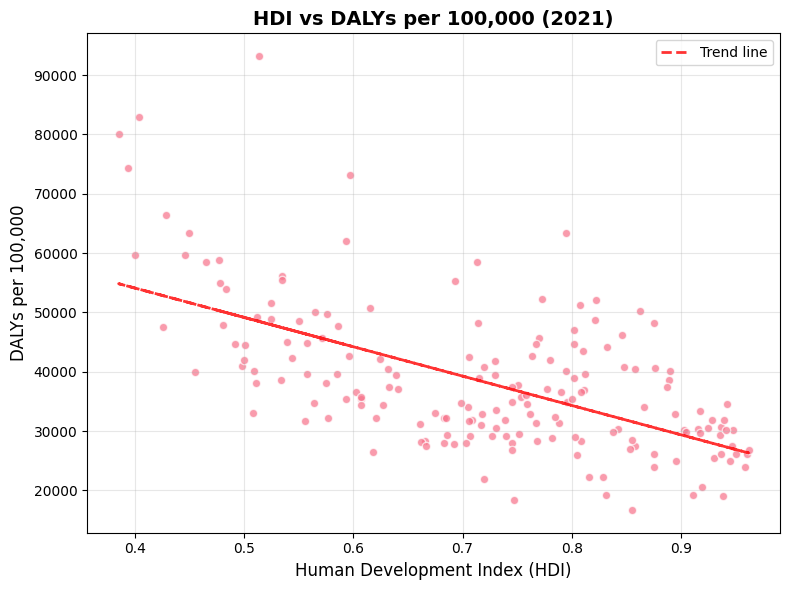

In [28]:
# Create scatter plot for HDI vs DALYs per 100k

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df2['hdi'], df2['dalys_rate'], alpha=0.7, edgecolors='white', linewidth=1)
plt.xlabel('Human Development Index (HDI)', fontsize=12)
plt.ylabel('DALYs per 100,000', fontsize=12)
plt.title('HDI vs DALYs per 100,000 (2021)', fontsize=14, fontweight='bold')

# Add trend line
z = np.polyfit(df2['hdi'], df2['dalys_rate'], 1)
p = np.poly1d(z)
plt.plot(df2['hdi'], p(df2['hdi']), "r--", alpha=0.8, linewidth=2, label='Trend line')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The graph shows a **negative correlation** between the Human Development Index (HDI) and Disability-Adjusted Life Years (DALYs) per 100,000 people for the year 2021. 

### Observations:
1. **Trend Line**:
   - The red dashed trend line indicates that as HDI increases, DALYs per 100,000 tend to decrease.
   - This supports the hypothesis that higher socioeconomic development (as measured by HDI) is associated with better health outcomes and lower disease burden.

2. **Data Distribution**:
   - Countries with lower HDI (below 0.6) generally have higher DALYs, often exceeding 50,000 per 100,000 people.
   - Countries with higher HDI (above 0.8) tend to have lower DALYs, typically below 30,000 per 100,000 people.

3. **Outliers**:
   - There are a few outliers with very high DALYs despite moderate HDI values (e.g., HDI around 0.5–0.6). These could represent countries facing unique health challenges or crises.

### Conclusion:
The graph visually confirms a **negative relationship** between HDI and DALYs, suggesting that improving HDI may lead to reduced health burdens globally. Further statistical analysis can quantify the strength of this relationship.

In [29]:
print("=== CORRELATION ANALYSIS: Human Development Index (HDI) vs DALYs per 100k ===\n")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df2['hdi'], df2['dalys_rate'])

# Calculate Pearson correlation for comparison
pearson_corr, pearson_p = pearsonr(df2['hdi'], df2['dalys_rate'])

print(f"Spearman Correlation Coefficient: {spearman_corr:.4f}")
print(f"Spearman p-value: {spearman_p:.6f}")
print(f"Statistical significance (α = 0.05): {'Yes' if spearman_p < 0.05 else 'No'}")
print()

print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Pearson p-value: {pearson_p:.6f}")
print(f"Statistical significance (α = 0.05): {'Yes' if pearson_p < 0.05 else 'No'}")
print()

# Interpret correlation strength
def interpret_correlation(corr_coef):
    abs_corr = abs(corr_coef)
    if abs_corr >= 0.7:
        strength = "Strong"
    elif abs_corr >= 0.5:
        strength = "Moderate"
    elif abs_corr >= 0.3:
        strength = "Weak"
    else:
        strength = "Very weak"
    
    direction = "negative" if corr_coef < 0 else "positive"
    return f"{strength} {direction}"

print("=== INTERPRETATION ===")
print(f"Spearman correlation interpretation: {interpret_correlation(spearman_corr)} correlation")
print(f"Pearson correlation interpretation: {interpret_correlation(pearson_corr)} correlation")
print()

# Hypothesis testing conclusion
print("=== HYPOTHESIS TESTING CONCLUSION ===")
print("Null Hypothesis (H₀): There is no correlation between HDI and DALYs per 100k")
print("Alternative Hypothesis (H₁): There is a correlation between HDI and DALYs per 100k")
print()

if spearman_p < 0.05:
    print(f"✓ REJECT the null hypothesis (p = {spearman_p:.6f} < 0.05)")
    print("✓ There IS a statistically significant correlation between HDI and DALYs per 100k")
    if spearman_corr < 0:
        print("✓ Higher HDI is associated with LOWER DALYs per 100k (supports hypothesis)")
    else:
        print("✗ Higher HDI is associated with HIGHER DALYs per 100k (contradicts hypothesis)")
else:
    print(f"✗ FAIL TO REJECT the null hypothesis (p = {spearman_p:.6f} ≥ 0.05)")
    print("✗ No statistically significant correlation found")

=== CORRELATION ANALYSIS: Human Development Index (HDI) vs DALYs per 100k ===

Spearman Correlation Coefficient: -0.5580
Spearman p-value: 0.000000
Statistical significance (α = 0.05): Yes

Pearson Correlation Coefficient: -0.5998
Pearson p-value: 0.000000
Statistical significance (α = 0.05): Yes

=== INTERPRETATION ===
Spearman correlation interpretation: Moderate negative correlation
Pearson correlation interpretation: Moderate negative correlation

=== HYPOTHESIS TESTING CONCLUSION ===
Null Hypothesis (H₀): There is no correlation between HDI and DALYs per 100k
Alternative Hypothesis (H₁): There is a correlation between HDI and DALYs per 100k

✓ REJECT the null hypothesis (p = 0.000000 < 0.05)
✓ There IS a statistically significant correlation between HDI and DALYs per 100k
✓ Higher HDI is associated with LOWER DALYs per 100k (supports hypothesis)


##### **Research Question 3**: How are mean years of schooling associated with DALYs from non-communicable disease?

The vast majority of NCDs, especially heart disease, many cancers, chronic respiratory disease, and diabetes are driven by behavioral risk factors like smoking, alcohol use, and diet. 

In [31]:
# Extract "Mean years of schooling - 2021" and "Country" from development_df
schooling_df = development_df[['Country', 'Mean years of schooling - 2021']].copy()
schooling_df.columns = ['country', 'mean_years_schooling']
schooling_df = schooling_df[schooling_df['mean_years_schooling'].notna()]
schooling_df['mean_years_schooling'] = pd.to_numeric(schooling_df['mean_years_schooling'], errors='coerce')
schooling_df = schooling_df.dropna()

# Extract rows where cause = "Non-communicable diseases" and year = 2021 from DALYs dataset
dalys_ncd_df = pd.read_csv('dataset/IMHE-GBD-lvl1-DALYs-per100k-2017-2021.csv')
dalys_ncd_df = dalys_ncd_df[(dalys_ncd_df['cause'] == 'Non-communicable diseases') & (dalys_ncd_df['year'] == 2021)]
dalys_ncd_df = dalys_ncd_df[['location', 'val']].copy()
dalys_ncd_df.columns = ['country', 'dalys_ncd_rate']
dalys_ncd_df = dalys_ncd_df[dalys_ncd_df['dalys_ncd_rate'].notna()]
dalys_ncd_df['dalys_ncd_rate'] = pd.to_numeric(dalys_ncd_df['dalys_ncd_rate'], errors='coerce')
dalys_ncd_df = dalys_ncd_df.dropna()

In [32]:
# Create df3 with schooling and DALYs from NCDs
df3 = schooling_df.merge(dalys_ncd_df, on='country', how='inner')

# Display basic info about df3
print(f"DataFrame shape: {df3.shape}")
print(f"Columns: {df3.columns.tolist()}")
print(f"Countries with complete data: {len(df3)}")
df3.head()

DataFrame shape: (179, 3)
Columns: ['country', 'mean_years_schooling', 'dalys_ncd_rate']
Countries with complete data: 179


,country,mean_years_schooling,dalys_ncd_rate
0,Switzerland,13.9,22434.01499
1,Norway,13.0,22309.50929
2,Iceland,13.8,20671.26553
3,Australia,12.7,22170.67936
4,Denmark,13.0,26051.44637


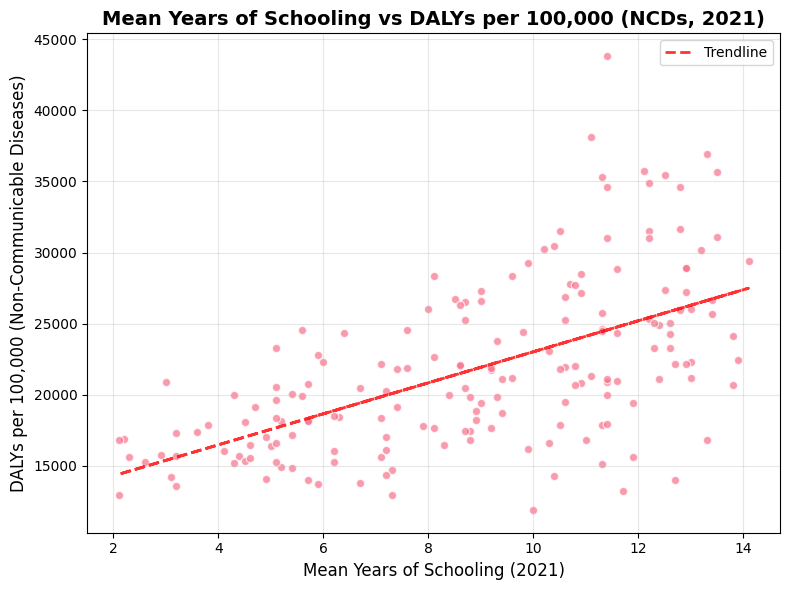

In [33]:
# Create scatter plot for Mean Years of Schooling vs DALYs from Non-Communicable Diseases

plt.figure(figsize=(8, 6))
plt.scatter(df3['mean_years_schooling'], df3['dalys_ncd_rate'], alpha=0.7, edgecolors='white', linewidth=1)
plt.xlabel('Mean Years of Schooling (2021)', fontsize=12)
plt.ylabel('DALYs per 100,000 (Non-Communicable Diseases)', fontsize=12)
plt.title('Mean Years of Schooling vs DALYs per 100,000 (NCDs, 2021)', fontsize=14, fontweight='bold')

# Add trendline
z = np.polyfit(df3['mean_years_schooling'], df3['dalys_ncd_rate'], 1)
p = np.poly1d(z)
plt.plot(df3['mean_years_schooling'], p(df3['mean_years_schooling']), "r--", alpha=0.8, linewidth=2, label='Trendline')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The graph shows a **positive correlation** between mean years of schooling and DALYs per 100,000 for non-communicable diseases (NCDs). This result may seem counterintuitive, as higher education levels are generally associated with better health outcomes. However, there are several possible explanations:

### 1. **Higher Education in Developed Countries**:
   - Countries with higher mean years of schooling often have better healthcare systems and diagnostic capabilities. This can lead to more accurate reporting and higher recorded DALYs for NCDs.
   - NCDs, such as heart disease, diabetes, and cancer, are more prevalent in developed countries due to lifestyle factors (e.g., sedentary behavior, processed diets).

### 2. **Lifestyle and Behavioral Factors**:
   - In countries with higher education levels, urbanization and industrialization often lead to unhealthy lifestyles, such as poor diets, lack of physical activity, and increased stress, which contribute to NCDs.

### 3. **Aging Populations**:
   - Countries with higher education levels often have aging populations, which are more susceptible to NCDs. Older populations contribute significantly to DALYs from chronic diseases.

### Conclusion:
While higher education is generally associated with better health outcomes, the relationship between mean years of schooling and DALYs for NCDs is influenced by complex factors, including lifestyle, aging populations, and data reporting practices.

##### **Research Question 4**: Can socioeconomic indicators predict the total DALYs of a country?
Variables: GDP per capita, HDI, Gini Index, Health Expenditure, Total DALYs per 100k

In [34]:
# Extract "Current health expenditure (% of GDP)" and "Gini index" from worldbank_df
health_exp_df = worldbank_df[worldbank_df.iloc[:, 0] == "Current health expenditure (% of GDP)"].copy()
health_exp_df.columns = ['indicator', 'country', 'country_code', 'health_expenditure']
health_exp_df = health_exp_df[['country', 'health_expenditure']].dropna()
health_exp_df['health_expenditure'] = pd.to_numeric(health_exp_df['health_expenditure'], errors='coerce')
health_exp_df = health_exp_df.dropna()

gini_df = worldbank_df[worldbank_df.iloc[:, 0] == "Gini index"].copy()
gini_df.columns = ['indicator', 'country', 'country_code', 'gini_index']
gini_df = gini_df[['country', 'gini_index']].dropna()
gini_df['gini_index'] = pd.to_numeric(gini_df['gini_index'], errors='coerce')
gini_df = gini_df.dropna()

In [35]:
# Merge datasets to create df4
df4 = dalys_clean.merge(gdp_df[['country', 'gdp_per_capita']], on='country', how='inner')
df4 = df4.merge(hdi_df[['country', 'hdi']], on='country', how='inner')
df4 = df4.merge(gini_df, on='country', how='inner')
df4 = df4.merge(health_exp_df, on='country', how='inner')

# Rename columns for clarity
df4.columns = ['country', 'dalys_rate_2021', 'gdp_per_capita_2021', 'hdi_2021', 'gini_index', 'health_expenditure']

# Display basic info about df4
print(f"DataFrame shape: {df4.shape}")
print(f"Columns: {df4.columns.tolist()}")
print(f"Countries with complete data: {len(df4)}")
df4.head()

DataFrame shape: (66, 6)
Columns: ['country', 'dalys_rate_2021', 'gdp_per_capita_2021', 'hdi_2021', 'gini_index', 'health_expenditure']
Countries with complete data: 66


,country,dalys_rate_2021,gdp_per_capita_2021,hdi_2021,gini_index,health_expenditure
0,Argentina,30304.34372,10738.017920,0.842,42.4,10.038322
1,Armenia,34508.08024,4685.179971,0.759,27.9,12.322685
2,Austria,30415.36700,53648.719070,0.916,30.7,12.152286
3,Belgium,30704.53906,51658.238290,0.937,26.6,11.047245
4,Benin,51655.81526,1318.651581,0.525,34.4,2.581295


=== Multiple Linear Regression ===
R² Score: 0.4623
Mean Squared Error: 110975104.24
Feature Coefficients:
gdp_per_capita_2021: -0.0777
hdi_2021: -36204.0560
gini_index: -365.4374
health_expenditure: -48.6236

=== Random Forest Regression ===
R² Score: 0.5289
Mean Squared Error: 97219489.90
Feature Importances:
gdp_per_capita_2021: 0.4124
hdi_2021: 0.4057
gini_index: 0.0975
health_expenditure: 0.0844


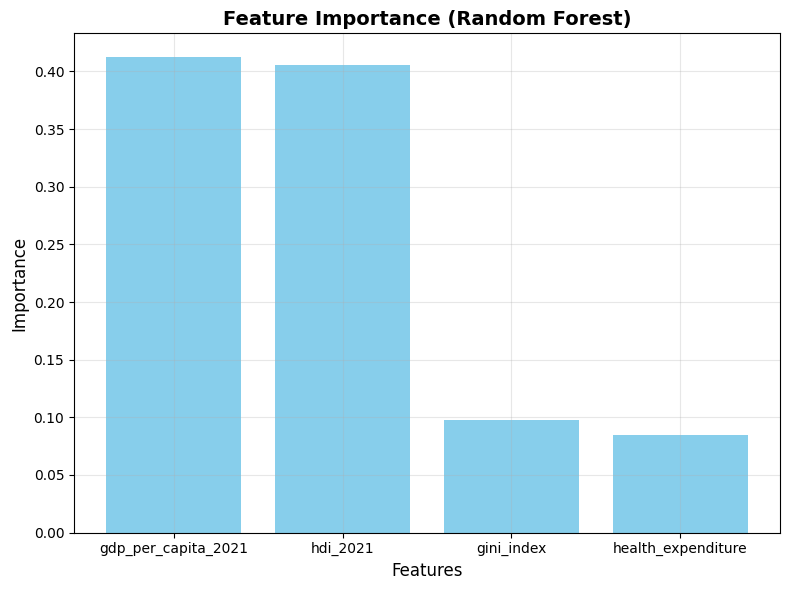

In [36]:
# linear regression
X = df4[['gdp_per_capita_2021', 'hdi_2021', 'gini_index', 'health_expenditure']]
y = df4['dalys_rate_2021']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multiple Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Evaluate Linear Regression
print("=== Multiple Linear Regression ===")
print(f"R² Score: {r2_score(y_test, y_pred_linear):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_linear):.2f}")
print("Feature Coefficients:")
for feature, coef in zip(X.columns, linear_model.coef_):
    print(f"{feature}: {coef:.4f}")

# Feature Importance using Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
print("\n=== Random Forest Regression ===")
print(f"R² Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_rf):.2f}")
print("Feature Importances:")
for feature, importance in zip(X.columns, rf_model.feature_importances_):
    print(f"{feature}: {importance:.4f}")

# Plot Feature Importance
plt.figure(figsize=(8, 6))
plt.bar(X.columns, rf_model.feature_importances_, color='skyblue')
plt.title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.ylabel('Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Analysis of Results:

#### **Multiple Linear Regression**
1. **R² Score**:
   - The R² score of **0.4623** indicates that approximately **46.23%** of the variance in DALYs is explained by the socioeconomic indicators (GDP, HDI, Gini Index, and health expenditure).
   - While this is a moderate level of explanatory power, it suggests that other factors not included in the model may also influence DALYs.

2. **Mean Squared Error (MSE)**:
   - The MSE of **110,975,104.24** reflects the average squared difference between predicted and actual DALYs. This value is relatively high, indicating that the model's predictions are not highly accurate.

3. **Feature Coefficients**:
   - All coefficients are **negative**, suggesting an inverse relationship between the predictors and DALYs:
     - **GDP per capita**: A small negative coefficient (-0.0777) implies that higher GDP per capita is weakly associated with lower DALYs.
     - **HDI**: A large negative coefficient (-36,204.0560) indicates that higher HDI is strongly associated with lower DALYs.
     - **Gini Index**: A moderate negative coefficient (-365.4374) suggests that higher inequality (Gini Index) is associated with lower DALYs, which may be counterintuitive and warrants further investigation.
     - **Health Expenditure**: A small negative coefficient (-48.6236) implies that higher health expenditure is weakly associated with lower DALYs.

#### **Random Forest Regression**
1. **R² Score**:
   - The R² score of **0.5289** indicates that the Random Forest model explains **52.89%** of the variance in DALYs, which is slightly better than the linear regression model.

2. **Mean Squared Error (MSE)**:
   - The MSE of **97,219,489.90** is lower than that of the linear regression model, suggesting that Random Forest provides more accurate predictions.

3. **Feature Importances**:
   - **GDP per capita (41.24%)** and **HDI (40.57%)** are the most important predictors, indicating that economic and developmental factors significantly influence DALYs.
   - **Gini Index (9.75%)** and **Health Expenditure (8.44%)** have lower importance, suggesting that inequality and health spending play a smaller role in predicting DALYs.

#### **Key Insights**
1. **Predictive Power**:
   - Both models show moderate predictive power, with Random Forest performing slightly better than Multiple Linear Regression.

2. **Importance of GDP and HDI**:
   - GDP per capita and HDI are the most influential predictors, highlighting the role of economic and developmental factors in determining health outcomes.

3. **Limitations**:
   - The relatively low R² scores suggest that other factors (e.g., environmental, behavioral, or healthcare access) may also significantly impact DALYs but are not included in the model.

4. **Model Selection**:
   - Random Forest is preferred for this analysis due to its higher R² score, lower MSE, and ability to capture non-linear relationships.

#### **Conclusion**
Socioeconomic indicators such as GDP per capita and HDI significantly predict DALYs, while Gini Index and health expenditure have a smaller impact. However, the moderate R² scores suggest that additional variables should be explored to improve the model's predictive power.

##### **Research Question 5**: Does the relationship between GDP per capita and total DALYs differ across regions?

In [ ]:
regions_df = pd.read_csv('dataset/regions.csv')

Columns in regions_df: Index(['Region', 'Country'], dtype='object')
DataFrame shape: (159, 3)
Columns: ['country', 'gdp_per_capita', 'Region']
Countries with complete data: 159


,country,gdp_per_capita,Region
0,Afghanistan,356.496214,South Asia
1,Albania,6413.282808,Eastern Europe
2,Algeria,4160.559267,MENA
3,Andorra,42425.699680,Western Europe
4,Angola,1925.874661,Sub-Saharan Africa


In [44]:
# Merge GDP and region data
df5 = gdp_df[['country', 'gdp_per_capita']].merge(
    regions_df[['Country', 'Region']],
    left_on='country', right_on='Country', how='inner'
)

# Drop the duplicate 'Country' column
df5 = df5.drop(columns=['Country'])

# Merge with DALY rates
df5 = df5.merge(dalys_clean[['country', 'dalys_rate']], on='country', how='inner')

df5['gdp_per_capita'] = pd.to_numeric(df5['gdp_per_capita'], errors='coerce')
df5['dalys_rate'] = pd.to_numeric(df5['dalys_rate'], errors='coerce')
df5 = df5.dropna(subset=['gdp_per_capita', 'dalys_rate', 'Region'])

# Display basic info about df5
print(f"DataFrame shape: {df5.shape}")
print(f"Columns: {df5.columns.tolist()}")
print(f"Countries with complete data: {len(df5)}")
df5.head()

DataFrame shape: (154, 4)
Columns: ['country', 'gdp_per_capita', 'Region', 'dalys_rate']
Countries with complete data: 154


,country,gdp_per_capita,Region,dalys_rate
0,Afghanistan,356.496214,South Asia,54970.40051
1,Albania,6413.282808,Eastern Europe,34816.53755
2,Algeria,4160.559267,MENA,28024.94386
3,Andorra,42425.699680,Western Europe,27497.83696
4,Angola,1925.874661,Sub-Saharan Africa,47727.66851


In [46]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# ANCOVA/Multiple regression with interaction:
model = smf.ols("dalys_rate ~ gdp_per_capita * C(Region)", data=df5).fit()
print(model.summary())

# ANOVA table to test significance of the interaction and other effects
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA Table:")
print(anova_table)

                            OLS Regression Results                            
Dep. Variable:             dalys_rate   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     8.370
Date:                Fri, 11 Jul 2025   Prob (F-statistic):           2.28e-15
Time:                        10:43:14   Log-Likelihood:                -1612.2
No. Observations:                 154   AIC:                             3266.
Df Residuals:                     133   BIC:                             3330.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

<Figure size 1000x600 with 0 Axes>

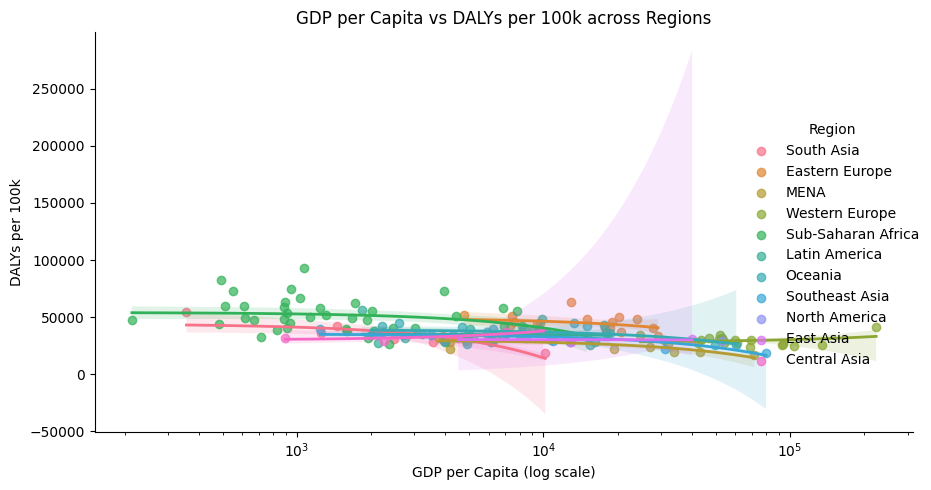

In [47]:
plt.figure(figsize=(10, 6))
sns.lmplot(x='gdp_per_capita', y='dalys_rate', hue='Region', data=df5, 
           aspect=1.5, scatter_kws={'alpha':0.7}, line_kws={'linewidth':2})
plt.xscale("log")
plt.xlabel("GDP per Capita (log scale)")
plt.ylabel("DALYs per 100k")
plt.title("GDP per Capita vs DALYs per 100k across Regions")
plt.tight_layout()
plt.show()

Analysis of Results

#### **Model Summary**
1. **R-squared**: 
   - The R-squared value of **0.557** indicates that approximately **55.7%** of the variance in DALYs is explained by the model, which includes GDP per capita, regions, and their interaction.
   - The adjusted R-squared of **0.491** accounts for the number of predictors and suggests a slightly lower explanatory power.

2. **F-statistic**:
   - The F-statistic of **8.370** with a p-value of **2.28e-15** indicates that the overall model is statistically significant.

3. **Coefficients**:
   - The **Intercept** is significant, suggesting a baseline DALYs rate across regions.
   - The coefficients for regions such as **Eastern Europe** and **Sub-Saharan Africa** are significant, indicating that these regions have distinct effects on DALYs compared to the reference region.
   - The interaction term **gdp_per_capita:C(Region)[T.South Asia]** is significant (p = 0.027), suggesting that the relationship between GDP per capita and DALYs differs significantly in South Asia compared to the reference region.

4. **Multicollinearity**:
   - The condition number (**6.22e+18**) and smallest eigenvalue indicate potential multicollinearity issues, which may affect the reliability of individual coefficients.

#### **ANOVA Table**
1. **Region Effect**:
   - The sum of squares for `C(Region)` is **1.01e+10**, with a highly significant p-value (**9.33e-14**). This confirms that regions have a significant effect on DALYs.

2. **GDP per Capita**:
   - The sum of squares for `gdp_per_capita` is **2.30e+08**, but the p-value (**0.101**) suggests that GDP per capita alone is not statistically significant.

3. **Interaction Effect**:
   - The interaction term `gdp_per_capita:C(Region)` has a significant p-value (**0.015**), indicating that the relationship between GDP per capita and DALYs varies across regions.

#### **Key Insights**
1. **Regional Differences**:
   - Regions such as **Eastern Europe** and **Sub-Saharan Africa** show significant differences in DALYs compared to the reference region, highlighting the importance of regional factors in health outcomes.

2. **Interaction Effect**:
   - The interaction between GDP per capita and regions is significant, particularly in **South Asia**, suggesting that socioeconomic development impacts DALYs differently across regions.

3. **Limitations**:
   - Multicollinearity may affect the reliability of individual coefficients.
   - The relatively moderate R-squared value suggests that other factors not included in the model may also influence DALYs.

#### **Conclusion**
The analysis confirms that the relationship between GDP per capita and DALYs varies significantly across regions, with South Asia showing a distinct interaction effect. Regional development and healthcare differences play a crucial role in shaping health outcomes. Further investigation into multicollinearity and additional predictors may improve the model's explanatory power.